# Example D

In this notebook, we will generate all the figures computed in Python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from qutip import destroy, num, steadystate, ssesolve, photocurrent_sesolve, spre, spost, to_super, vector_to_operator, operator_to_vector, wigner
from scipy import signal
from scipy.integrate import trapz
from FCS import TwoTimeCorrelationSS, FCSPowerSpectrumLinear

plt.rcParams.update({
    "text.usetex": True,
    "font.size" : 24})

# Wigner plots

In [2]:
# Define Hamiltonian function
def Ham(G, U, Δ, a):
    
    return ((G/2) * a**2 + np.conj(G/2) *  a.dag()**2) + (U/2)*a.dag()**2 * a**2  - Δ*a.dag()*a

# Define parameters
na = 3
G = [0.3j, 1, 1]
U = [0, 1/3, 1/3]
κ =  1
Δ = [0, 0, 2]
N = 30

# Define system operators
a = destroy(N)
n = a.dag()*a
x = (a + a.dag())/np.sqrt(2)
p = -1j*(a - a.dag())/np.sqrt(2)

# Get Hamiltonians
H0, H1, H2 = [Ham(G[i], U[i], Δ[i], a) for i in range(3)]

# Define collapse operator
c_ops = [np.sqrt(κ)*a]

# Compute steady states
rho0, rho1, rho2 = [steadystate(Hi, c_ops) for Hi in [H0, H1, H2]]

In [3]:
# Get wigner function
X = P = np.linspace(-6, 6, 300)

# Make meshgrid
XX, PP = np.meshgrid(X, P)

# Compute Wigner functions
w_list = [wigner(rhoi, X, P) for rhoi in [rho0, rho1, rho2]]

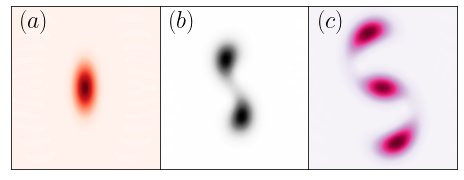

In [4]:
fig, axs = plt.subplots(1,3,sharex=True,sharey=True,figsize=(8,3))


ccolors = ['Reds','Greys','PuRd']
LETTERS = [r"$(a)$",r"$(b)$",r"$(c)$"]

for i, ax in enumerate(axs.flat):
    ax.contourf(X, X, w_list[i], 100, cmap = plt.cm.get_cmap(ccolors[i]))
        
    ax.annotate(LETTERS[i], (0.07,0.87), fontsize = 24, xycoords="axes fraction")
    
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# Study trajectories of Homodyne and Photocurrent using Wigner function c)

In [5]:
# Take first eigenstate as initial solution (for ssesolve which is faster)
psi0 = rho2.eigenstates()[1][0]

In [6]:
# Define time parameters of the system
tm = 0
tM = 800
ts = 0.01
dt = ts
fs = int(1/ts)
t = np.arange(tm, tM, ts)

# Dictionary of observables
e_dict = {'n': n,
         'p': p,
         }
# Specify observables
e_ops = list(e_dict.values())

### Compute Homodyne trajectory

In [7]:
ntraj = 1   # Number of trajectories to average over
nsubsteps = 20

# Here we use ssesolve instead of smesolve since it is faster than keeping track of the whole desnity matrix
output_hom1 = ssesolve(H2, psi0, t, 
                        c_ops = [],
                        sc_ops = c_ops,
                        ntraj=ntraj, 
                        e_ops = e_ops,
                        nsubsteps=nsubsteps,
                        method='homodyne',
                        store_measurement=True,
                        noise=3)

# Create dictionary of observables
e_t_hom = {key: out for key, out in zip(e_dict, output_hom1.expect)}

Total run time:  25.52s


In [8]:
# Get homodyne current
Ihom = np.real(output_hom1.measurement[0].T[0])

# Pass through lowpass butterworth filter
sos = signal.butter(1, 0.05, 'low', fs=fs, output='sos')
filtered = signal.sosfilt(sos, Ihom)

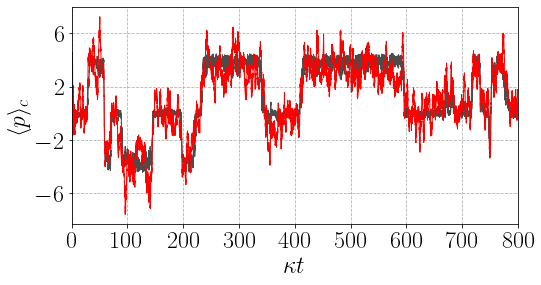

In [9]:
fig = plt.figure(figsize=(8, 4))

plt.plot(t, e_t_hom['p'], color='k' ,label=r'$\langle p \rangle_{c}$', alpha=0.7, linewidth=1)
plt.plot(t, -2*filtered, color='r' ,label=r'$\tilde{I}_{\rm diff}(t)$', alpha=1, linewidth=1)
plt.ylabel(r'$\langle p \rangle_{c}$')
plt.grid(True, linestyle='--')
plt.yticks(np.arange(-6, 10, 4))

plt.xlim([0, 800])
plt.xticks(np.arange(0, 900, 100))
plt.xlabel(r'$\kappa t$')

plt.xlim([tm, tM])

plt.show()

### Compute Photocurrent trajectory

In [10]:
output_photo = photocurrent_sesolve(H2, psi0, t, 
                        c_ops = [],
                        sc_ops = c_ops,
                        ntraj=ntraj, 
                        e_ops = e_ops,
                        nsubsteps=nsubsteps, store_measurement=True, noise=7)

# Create dictionary of observables
e_t_photo = {key: out for key, out in zip(e_dict, output_photo.expect)}

Total run time:   6.04s


In [11]:
# Get photocurrent
detections = np.real(output_photo.measurement[0].T[0])*dt

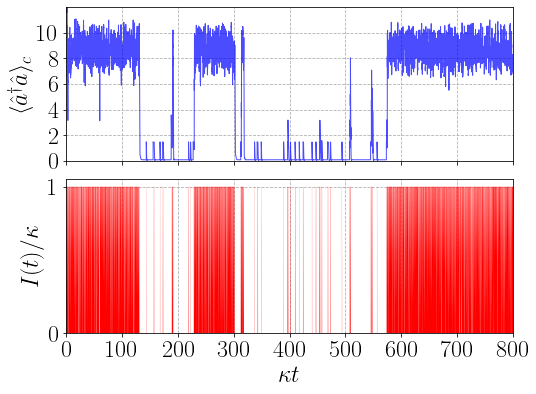

In [12]:
fig = plt.figure(figsize=(8, 6))

Grid = gridspec.GridSpec(2, 1)

ax1 = plt.subplot(Grid[0, 0])

ax1.plot(t, e_t_photo['n'], color='b' ,label=r'$\langle x \rangle$', alpha=0.7, linewidth=1)

ax1.set_ylabel(r'$\langle \hat{a}^{\dagger}\hat{a} \rangle_{c}$')
ax1.tick_params(axis='y', labelcolor='k')
ax1.tick_params(axis='x')
ax1.grid(True, linestyle='--')
ax1.set_yticks(np.arange(0, 12, 2))
ax1.set_ylim([0, 12])
ax1.set_xlim([0, 800])
ax1.set_xticks(np.arange(0, 900, 100))
ax1.set_xticklabels([])
ax1.grid(True)

ax2 = plt.subplot(Grid[1, 0])

ax2.plot(t, np.sign(detections), color='r' ,label=r'$\langle x \rangle$', alpha=1, linewidth=0.1)

ax2.set_xlabel(r'$\kappa t$')
ax2.set_ylabel(r'$I(t)/\kappa$')
ax2.grid(True, linestyle='--')
ax2.set_xlim([0, 800])
ax2.set_yticks([0,1])
ax2.set_xticks(np.arange(0, 900, 100))
ax2.set_ylim([0,1.05])
ax2.grid(True)

plt.subplots_adjust(hspace = 0.12, wspace = 0)

plt.show()


# Compute Tilted Liouvillian

It will be useful to reduce the N dimension here (since this method is computationally heavy) and compute this for the case of when $\Delta = 0$

In [17]:
# New system parameters
N = 15
Δ = 0

# Define system operators
a = destroy(N)
n = num(N)
x = (a + a.dag())/np.sqrt(2)
p = -1j*(a - a.dag())/np.sqrt(2)

# Compute Hamiltonian, collapse operators
H = Ham(1, 1/3, 0, a)
c_ops = [np.sqrt(κ)*a]

# Compute steadystate
rhoss = steadystate(H, c_ops)

In [18]:
def tilted_liouvillian(H, L, chi, v):
    
    # Only works for one jump operator
    H_vec = spre(H) - spost(H)
    L_vec = np.exp(1j*chi*v)*to_super(L) - 0.5*(spre(L.dag() * L) + spost(L.dag()*L))
    
    return -1j*H_vec + L_vec

In [19]:
# Compute vectorised density operator
rhovec = operator_to_vector(rhoss)

# Create chi space
chi = np.linspace(-np.pi, np.pi, 100)
dchi = chi[1]-chi[0]

t = [1, 10, 20, 30]

# Compute tilted Liouvillians
liouvs = [tilted_liouvillian(H, c_ops[0], i, 1) for i in chi]
rhochi = [[vector_to_operator((liou * ti).expm()*rhovec) for liou in liouvs] for ti in t]

# Take trace of all rhochis
pchis = np.array([[rho.tr() for rho in rhoix] for rhoix in rhochi])

In [20]:
#Compute n vals
n = np.arange(0, 200)

# Peform Fourier transform
Pnt = np.abs([trapz(np.exp(-1j*ni*chi)*pchis, chi, dx=dchi, axis=1) for ni in n])/(2*np.pi)

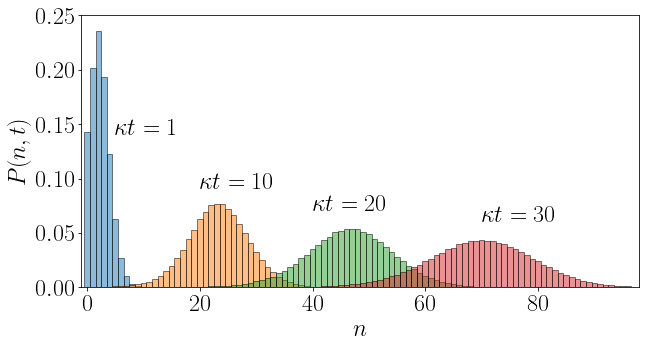

In [21]:
fig = plt.figure(figsize=(10, 5))

plt.bar(n, Pnt.T[0], width = 1, alpha=0.5, edgecolor = 'k')
plt.bar(n, Pnt.T[1], width = 1, alpha=0.5, edgecolor = 'k')
plt.bar(n, Pnt.T[2], width = 1, alpha=0.5, edgecolor = 'k')
plt.bar(n, Pnt.T[3], width = 1, alpha=0.5, edgecolor = 'k')

plt.xlim([-1,98])
plt.ylim([0, 0.25])

plt.text(5, 0.14, r'$\kappa t=1$')
plt.text(20, 0.09, r'$\kappa t=10$')
plt.text(40, 0.07, r'$\kappa t=20$')
plt.text(70, 0.06, r'$\kappa t=30$')

plt.xlabel(r'$n$')
plt.ylabel(r'$P(n,t)$')

plt.show()